In [1]:
import GPyOpt
from GPyOpt.methods import BayesianOptimization
import numpy as np
import pandas as pd
from pyomo.environ import *
# For saving date time
from datetime import datetime
import time
# For define constrains
import textwrap
import re
import inspect
# For plot
import matplotlib.pyplot as plt

In [2]:
start_time = datetime.fromtimestamp(time.time())

data_path = r'DataSet\9node\\'

candid = pd.read_excel(data_path + 'candid9.xlsx', sheet_name='Sheet1')
deltalink = pd.read_excel(data_path + 'deltalink9.xlsx', sheet_name='Sheet1')
facilitycap = pd.read_excel(data_path + 'capfac9.xlsx', sheet_name='Sheet1')
nodedem = pd.read_excel(data_path + 'demand9.xlsx', sheet_name='Sheet1')
linkcap = pd.read_excel(data_path + 'caplink9.xlsx', sheet_name='Sheet1')
linkfreecost = pd.read_excel(data_path + 'freeflow9.xlsx', sheet_name='Sheet1')
qod = 5 * pd.read_excel(data_path + 'xod9.xlsx', sheet_name='Sheet1')   
numod = pd.read_excel(data_path + 'numod9.xlsx', sheet_name='Sheet1')
deltaod = pd.read_excel(data_path + 'deltaod9.xlsx', sheet_name='Sheet1')
fixedfacility = pd.read_excel(data_path + 'fixedcost9.xlsx', sheet_name='Sheet1')

capincreas = [136, 146, 112, 119, 111, 126, 126, 101, 120, 125, 143, 143, 129,
              103, 109, 101, 149, 148, 111, 128, 133, 133, 112, 100, 125, 122,
              127, 107, 113, 129, 146, 129, 121]
capcost = 10*[294, 342, 212, 230, 103, 128, 319, 296, 253, 342, 280, 202, 271,
              345, 208, 273, 272, 272, 201, 306, 343, 169, 192, 346, 284, 296,
              168, 197, 172, 295, 236, 285, 148]
    
inflow = [192,116,135,115,127,132,122,159,129]
outflow = [65,163,142,84,153,159,154,182,125]
  
end_time = datetime.fromtimestamp(time.time())
print('Total time for read data: ', end_time - start_time)

Total time for read data:  0:00:00.675627


In [3]:
[numlink, numpath] = np.shape(deltalink)
(a, numfacility) = np.shape(facilitycap)
(b, numcustomer) = np.shape(nodedem)
# sets
Model.setpath = range(numpath)
Model.setfacility = range(numfacility)
Model.setcustomer = range(numcustomer)
Model.setlink = range(numlink)

In [4]:
linkcap4 = np.zeros(numlink)
for e in Model.setlink:
        linkcap4[e] = linkcap.iloc[0,e]**4

In [5]:
def objfunc2d(x):    
    Model = AbstractModel()
    xe = np.zeros(([1, numlink]))
    y = np.zeros(([1, numfacility]))
    for k in Model.setlink:
        xe[0,k] = x[:,k]
            
    print(xe)
    Model._fprimrsk = Var(Model.setpath, within = NonNegativeReals)
    Model._ve = Var(Model.setlink, within = NonNegativeReals)
    
    def fobjective(Model):
        return sum(linkfreecost.iloc[0,e]*(Model._ve[e]+0.15*Model._ve[e]**5/
                                               (5*((linkcap.iloc[0,e]+xe[0,e]*capincreas[e])**4))) for e in Model.setlink)
    Model.obj = Objective(rule = fobjective, sense = minimize)

    def cons4(Model, r, s):
        return sum(Model._fprimrsk[k]*deltaod.iloc[numod.iloc[r,s]-1,k]  for k in Model.setpath) == qod.iloc[r,s]
    Model.con4 = Constraint(Model.setcustomer, Model.setcustomer, rule=cons4)
 
    def cons5(Model, e):
        return sum((Model._fprimrsk[k])*deltalink.iloc[e,k]  for k in Model.setpath) == Model._ve[e]
    Model.con5 = Constraint(Model.setlink, rule = cons5) 
        
    NTA0 = Model.create_instance()
    opt = SolverFactory('ipopt')
    opt.solve(NTA0)
    return sum(linkfreecost.iloc[0,e]*(1+0.15*NTA0._ve[e].value**4/
                                               (((linkcap.iloc[0,e]+xe[0,e]*capincreas[e])**4))) for e in Model.setlink)

bounds = [{'name': 'xe', 'type': 'discrete', 'domain': (0,1), 'dimensionality':numlink}]

In [6]:
def constraint_to_string(constraint_function):
    source_code = inspect.getsource(constraint_function)    
    # Remove whitespaces and indentation
    source_code = textwrap.dedent(source_code)    
    # Extract the constraint expression
    constraint_expression = re.search(r'return\s+(.*)(\s)*$', source_code, re.MULTILINE).group(1)    
    return constraint_expression

## For 5

In [7]:
start_time5 = datetime.fromtimestamp(time.time())

def budget_constraint(x):
    return sum(x[:, e] for e in range(33)) - 5

constraint5 = constraint_to_string(budget_constraint)
constraints_5 = [{'name': 'budget_con', 'constraint': constraint5}]

#Determine the subset where we are allowed to sample
feasible_region = GPyOpt.Design_space(space = bounds, constraints = constraints_5) 
initial_design = GPyOpt.experiment_design.initial_design('random', feasible_region, 5)

#CHOOSE the objective
objective = GPyOpt.core.task.SingleObjective(objfunc2d)

# CHOOSE the model type
model = GPyOpt.models.GPModel(exact_feval=True, optimize_restarts = 5, verbose = False)

#CHOOSE the acquisition optimizer
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(feasible_region)

#CHOOSE the type of acquisition
acquisition = GPyOpt.acquisitions.AcquisitionEI(model, feasible_region, optimizer = aquisition_optimizer)

#CHOOSE a collection method
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

# Now create BO object
bo5 = GPyOpt.methods.ModularBayesianOptimization(model, feasible_region, objective, acquisition, evaluator, initial_design)

# --- Stop conditions
max_time  = 15 
max_iter  = 10
tolerance = 1e-2     # distance between two consecutive observations 
                     # if we're sampling a region in such fine detail then it is likely that we've found the true min.

# Run the optimization
bo5.run_optimization(max_iter = max_iter, max_time = max_time, eps = tolerance, verbosity = False)

end_time5 = datetime.fromtimestamp(time.time())
print('Total time for 5 selected edges: ', end_time5 - start_time5)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 1. 0. 0. 0. 0. 0. 1.]]
[[0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 1. 0. 0. 0.]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 1. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 1. 0.]]
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 1. 0.]]
Total time for 5 selected edges:  0:01:25.714959


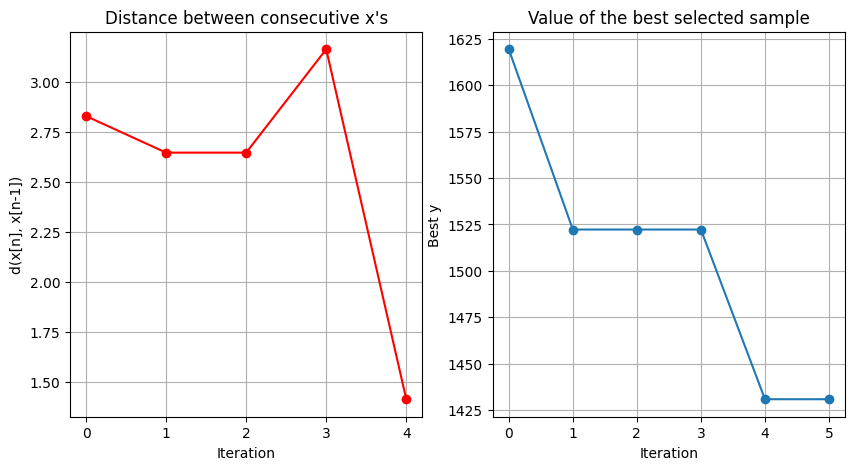

In [8]:
bo5.plot_convergence()

In [9]:
print(bo5.x_opt)
print(bo5.fx_opt)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 0.]
1430.9139826699882


## For 10

In [10]:
start_time10 = datetime.fromtimestamp(time.time())

def budget_constraint(x):
    return sum(x[:, e] for e in range(33)) - 10

constraint10 = constraint_to_string(budget_constraint)
constraints_10 = [{'name': 'budget_con', 'constraint': constraint10}]

#Determine the subset where we are allowed to sample
feasible_region = GPyOpt.Design_space(space = bounds, constraints = constraints_10) 
initial_design = GPyOpt.experiment_design.initial_design('random', feasible_region, 5)

#CHOOSE the objective
objective = GPyOpt.core.task.SingleObjective(objfunc2d)

# CHOOSE the model type
model = GPyOpt.models.GPModel(exact_feval=True, optimize_restarts = 5, verbose = False)

#CHOOSE the acquisition optimizer
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(feasible_region)

#CHOOSE the type of acquisition
acquisition = GPyOpt.acquisitions.AcquisitionEI(model, feasible_region, optimizer = aquisition_optimizer)

#CHOOSE a collection method
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

# Now create BO object
bo10 = GPyOpt.methods.ModularBayesianOptimization(model, feasible_region, objective, acquisition, evaluator, initial_design)
# --- Stop conditions
max_time  = 30
max_iter  = 20
tolerance = 1e-2     # distance between two consecutive observations 
                     # if we're sampling a region in such fine detail then it is likely that we've found the true min.

# Run the optimization
bo10.run_optimization(max_iter = max_iter, max_time = max_time, eps = tolerance, verbosity = False)

end_time10 = datetime.fromtimestamp(time.time())
print('Total time for 10 selected edges: ', end_time10 - start_time10)

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1.
  0. 0. 0. 0. 1. 1. 0. 0. 0.]]
[[1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0.
  0. 0. 1. 0. 1. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
  0. 0. 0. 0. 0. 0. 1. 0. 1.]]
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0.
  0. 0. 0. 0. 1. 1. 1. 0. 0.]]
[[0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 1. 1. 0. 0. 0. 0. 0. 1.]]
[[1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0.]]
[[1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 1. 1. 0. 0. 0.]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0.
  0. 0. 1. 1. 1. 0. 0. 0. 0.]]
[[0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0.
  0. 0. 1. 0. 1. 0. 0. 0. 0.]]
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.

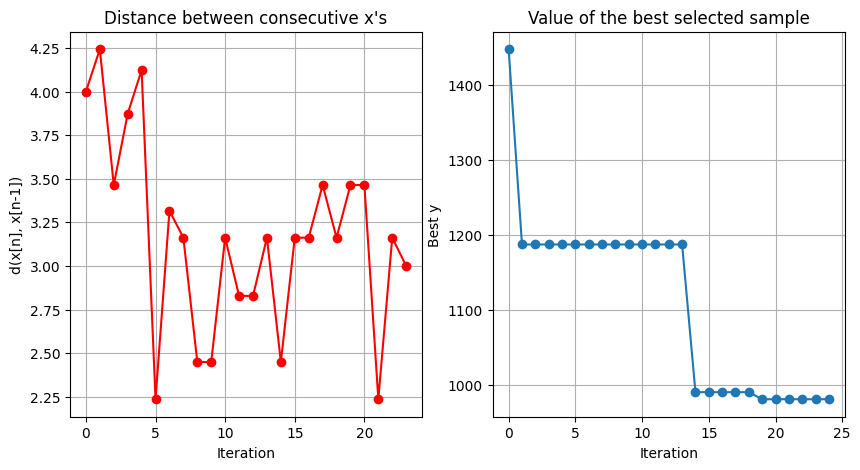

In [11]:
bo10.plot_convergence()

In [12]:
print(bo10.x_opt)
print(bo10.fx_opt)

[0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 0.]
981.176379407339


## For 15

In [13]:
start_time15 = datetime.fromtimestamp(time.time())

def budget_constraint(x):
    return sum(x[:, e] for e in range(33)) - 15

constraint15 = constraint_to_string(budget_constraint)
constraints_15 = [{'name': 'budget_con', 'constraint': constraint15}]

#Determine the subset where we are allowed to sample
feasible_region = GPyOpt.Design_space(space = bounds, constraints = constraints_15) 
initial_design = GPyOpt.experiment_design.initial_design('random', feasible_region, 5)

#CHOOSE the objective
objective = GPyOpt.core.task.SingleObjective(objfunc2d)

# CHOOSE the model type
model = GPyOpt.models.GPModel(exact_feval=True, optimize_restarts = 5, verbose = False)

#CHOOSE the acquisition optimizer
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(feasible_region)

#CHOOSE the type of acquisition
acquisition = GPyOpt.acquisitions.AcquisitionEI(model, feasible_region, optimizer = aquisition_optimizer)

#CHOOSE a collection method
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

# Now create BO object
bo15 = GPyOpt.methods.ModularBayesianOptimization(model, feasible_region, objective, acquisition, evaluator, initial_design)
# --- Stop conditions
max_time  = 45
max_iter  = 30
tolerance = 1e-2     # distance between two consecutive observations 
                     # if we're sampling a region in such fine detail then it is likely that we've found the true min.

# Run the optimization
bo15.run_optimization(max_iter = max_iter, max_time = max_time, eps = tolerance, verbosity = False)

end_time15 = datetime.fromtimestamp(time.time())
print('Total time for 15 selected edges: ', end_time15 - start_time15)

[[0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1.
  1. 1. 0. 0. 1. 1. 0. 0. 0.]]
[[1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1.
  1. 1. 0. 0. 0. 0. 1. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0.
  1. 1. 0. 0. 0. 0. 1. 0. 0.]]
[[0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0.
  1. 0. 0. 1. 0. 1. 0. 0. 0.]]
[[0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1.
  0. 1. 0. 1. 1. 0. 0. 1. 1.]]
[[1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0.
  1. 0. 0. 0. 0. 1. 1. 0. 0.]]
[[0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0.
  1. 0. 0. 0. 0. 1. 1. 0. 0.]]
[[0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.
  1. 0. 1. 1. 0. 1. 1. 0. 1.]]
[[0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 1. 0. 1.]]
[[0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1.

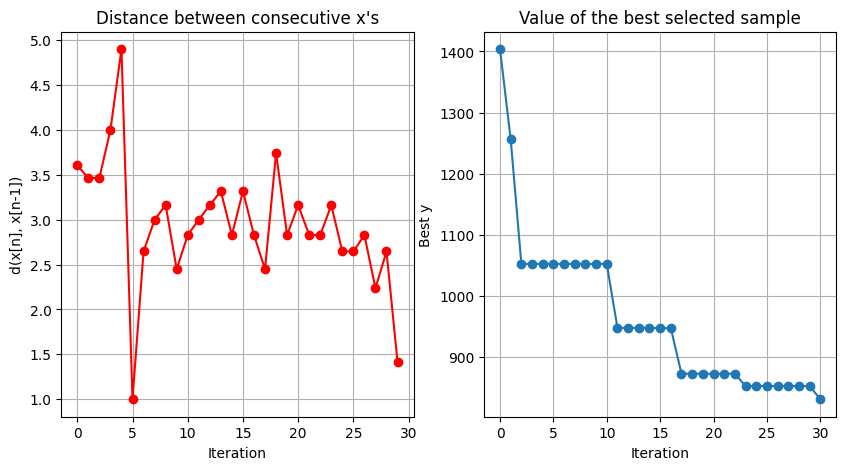

In [14]:
bo15.plot_convergence()

In [15]:
print(bo15.x_opt)
print(bo15.fx_opt)

[1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0.
 0. 0. 1. 1. 0. 0. 1. 0. 0.]
830.9472689433874


## For 20

In [23]:
start_time20 = datetime.fromtimestamp(time.time())

def budget_constraint(x):
    return sum(x[:, e] for e in range(33)) - 20

constraint20 = constraint_to_string(budget_constraint)
constraints_20 = [{'name': 'budget_con', 'constraint': constraint20}]

#Determine the subset where we are allowed to sample
feasible_region = GPyOpt.Design_space(space = bounds, constraints = constraints_20) 
initial_design = GPyOpt.experiment_design.initial_design('random', feasible_region, 5)

#CHOOSE the objective
objective = GPyOpt.core.task.SingleObjective(objfunc2d)

# CHOOSE the model type
model = GPyOpt.models.GPModel(exact_feval=True, optimize_restarts = 5, verbose = False)

#CHOOSE the acquisition optimizer
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(feasible_region)

#CHOOSE the type of acquisition
acquisition = GPyOpt.acquisitions.AcquisitionEI(model, feasible_region, optimizer = aquisition_optimizer)

#CHOOSE a collection method
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

# Now create BO object
bo20 = GPyOpt.methods.ModularBayesianOptimization(model, feasible_region, objective, acquisition, evaluator, initial_design)

# --- Stop conditions
max_time  = 60
max_iter  = 40
tolerance = 1e-2     # distance between two consecutive observations 
                     # if we're sampling a region in such fine detail then it is likely that we've found the true min.

# Run the optimization
bo20.run_optimization(max_iter = max_iter, max_time = max_time, eps = tolerance, verbosity = False)

end_time20 = datetime.fromtimestamp(time.time())
print('Total time for 20 selected edges: ', end_time20 - start_time20)

[[1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 1. 0. 0. 1. 0.]]
[[0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1.
  1. 1. 1. 0. 0. 1. 1. 1. 0.]]
[[0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0.
  1. 1. 0. 0. 0. 0. 0. 0. 0.]]
[[1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0.
  0. 1. 1. 1. 0. 1. 0. 0. 0.]]
[[1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0.
  0. 1. 0. 0. 0. 1. 1. 1. 0.]]
[[0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0.
  1. 0. 0. 0. 0. 1. 1. 1. 0.]]
[[0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0.
  1. 0. 0. 0. 0. 1. 1. 1. 0.]]
[[0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0.
  1. 1. 1. 0. 0. 1. 1. 1. 0.]]
[[0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1.
  1. 1. 1. 0. 0. 1. 1. 1. 1.]]
[[1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.

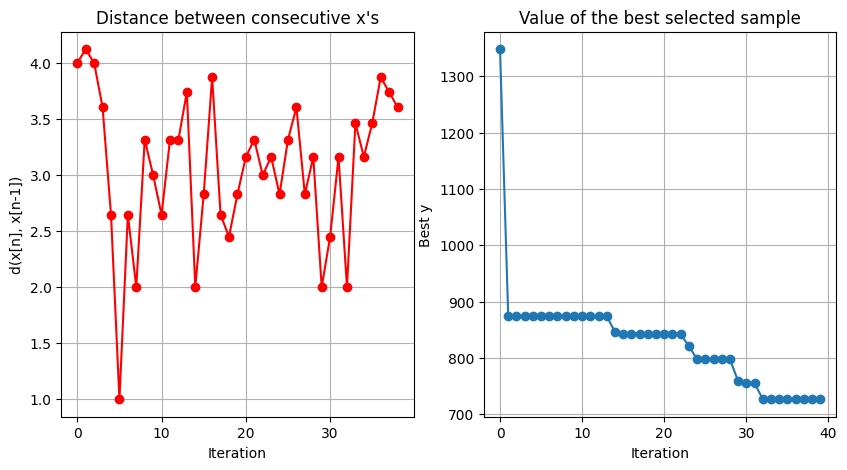

In [24]:
bo20.plot_convergence()

In [25]:
print(bo20.x_opt)
print(bo20.fx_opt)

[0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0.
 0. 1. 0. 1. 0. 1. 1. 1. 0.]
726.630774067291


### Selected edges

In [68]:
indices_array5  = np.where(np.array(bo5.x_opt) == 1)[0] + 1
indices_array10 = np.where(np.array(bo10.x_opt) == 1)[0] + 1
indices_array15 = np.where(np.array(bo15.x_opt) == 1)[0] + 1
indices_array20 = np.where(np.array(bo20.x_opt) == 1)[0] + 1
print("Selected edges for 5 = ", tuple(indices_array5), "\nSelected edges for 10 = ", tuple(indices_array10),
      "\nSelected edges for 15 = ", tuple(indices_array15), "\nSelected edges for 20 = ", tuple(indices_array20),
      "\nBayesian optimization function for 5 = ", bo5.fx_opt, "\nBayesian optimization function for 10 = ", bo10.fx_opt,
       "\nBayesian optimization function for 15 = ", bo15.fx_opt, "\nBayesian optimization function for 20 = ", bo20.fx_opt)

Selected edges for 5 =  (10, 18, 21, 25, 32) 
Selected edges for 10 =  (2, 3, 6, 10, 11, 15, 18, 21, 26, 31) 
Selected edges for 15 =  (1, 2, 6, 7, 10, 11, 15, 18, 19, 20, 21, 23, 27, 28, 31) 
Selected edges for 20 =  (2, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 18, 19, 20, 21, 26, 28, 30, 31, 32) 
Bayesian optimization function for 5 =  1430.9139826699882 
Bayesian optimization function for 10 =  981.176379407339 
Bayesian optimization function for 15 =  830.9472689433874 
Bayesian optimization function for 20 =  726.630774067291


In [47]:
bayesian_optimization = [bo5.fx_opt, bo10.fx_opt, bo15.fx_opt, bo20.fx_opt]
selected_edges = [5, 10, 15, 20]

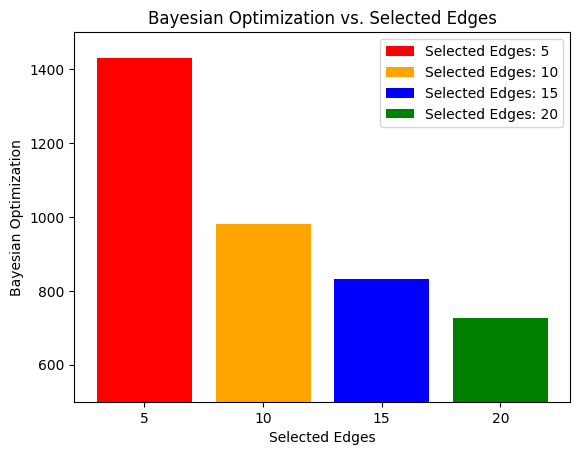

In [60]:
colors = ['red', 'orange', 'blue', 'green']

for i, (bo, edge) in enumerate(zip(bayesian_optimization, selected_edges)):
    plt.bar(str(edge), bo, color=colors[i], label=f'Selected Edges: {edge}')

plt.ylim(min(min(bayesian_optimization), 500), max(max(bayesian_optimization), 1500))

plt.xlabel('Selected Edges')
plt.ylabel('Bayesian Optimization')
plt.title('Bayesian Optimization vs. Selected Edges')
plt.legend()
plt.show()

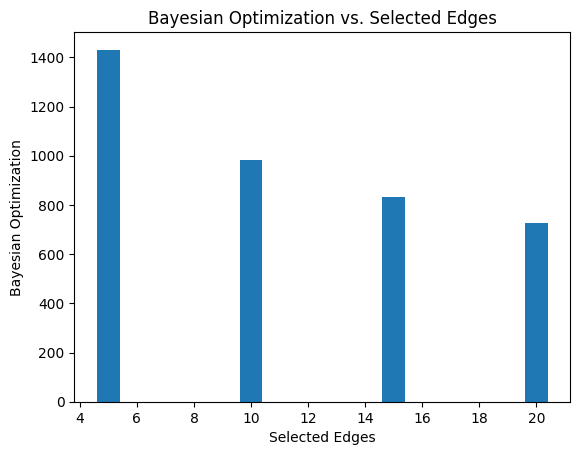

In [61]:
plt.bar(selected_edges, bayesian_optimization)
plt.xlabel('Selected Edges')
plt.ylabel('Bayesian Optimization')
plt.title('Bayesian Optimization vs. Selected Edges')
plt.show()

In [72]:
from collections import Counter

data = {tuple(indices_array5), tuple(indices_array10), tuple(indices_array15), tuple(indices_array20)}

all_edges = [edge for edges_tuple in data for edge in edges_tuple]
edge_counts = Counter(all_edges)
top_5_edges = edge_counts.most_common(5)

# Print the top 5 edges and their occurrences
for edge, count in top_5_edges:
    print(f"Edge {edge}: Occurrences {count}")


Edge 10: Occurrences 4
Edge 18: Occurrences 4
Edge 21: Occurrences 4
Edge 2: Occurrences 3
Edge 6: Occurrences 3
